# 0. Data preparation
#### (see first notebook)

In [1]:
! pip install scikit-learn==1.2

In [2]:
! pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\paola\.conda\lib\site-packages (0.10.1)


In [3]:
#Basic imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, recall_score, f1_score, precision_score, accuracy_score

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [5]:
#Load in lung cancer datasets
data = pd.read_csv("lung_cancer_data.csv")

In [6]:
#Create dummy variables (see first notebook)
data_no_cat = data.copy()

#Clean so 1 is YES and 0 is NO.
#First replace all 1s by 0s (ok as AGE has min values>>1)
data_no_cat.replace({1:0},inplace=True)

#Now replace all 2s by 1s
data_no_cat.replace({2:1},inplace=True)

#Now create dummy variable for GENDER and LUNG_CANCER
data_no_cat=pd.get_dummies(data_no_cat,drop_first=True)

# I. Most important features

In the previous notebooks, we have already explored many features individually. However, we will now begin to consider them altogether and decide on which ones should be most relevant in our model.

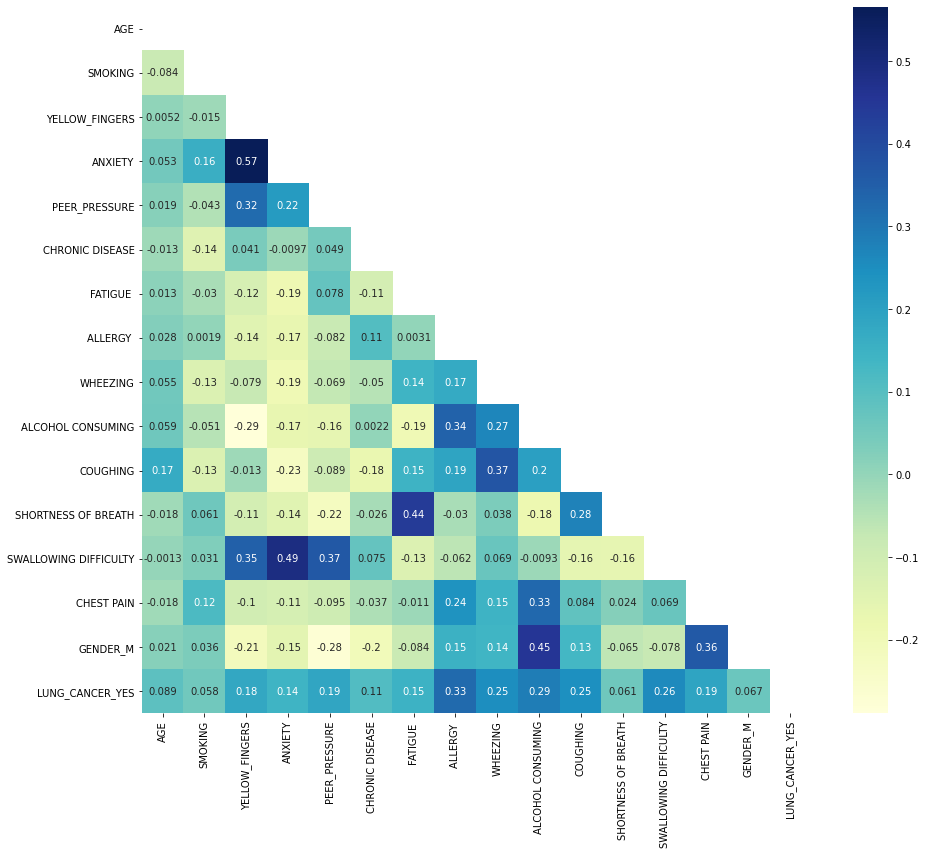

In [7]:
plt.figure(figsize = (15,13))

# creating mask
mask = np.triu(np.ones_like(data_no_cat.corr()))
 
# plotting a triangle correlation heatmap
sns.heatmap(data_no_cat.corr(), cmap="YlGnBu", annot=True, mask=mask);

As a rule of thumb, if 2 features are highly correlated, one can be dropped to improve performance. The top ones that we might think of dropping are:

1) Yellow fingers (which is highly correlated to anxiety).

2) Swallowing difficulty (which is highly correlated to anxiety, peer-pressure and yellow-fingers).

(or anxiety for two above)

3) Gender which is correlated to alcohol.

Before dropping those, we will test the model performance with and without those selected features.

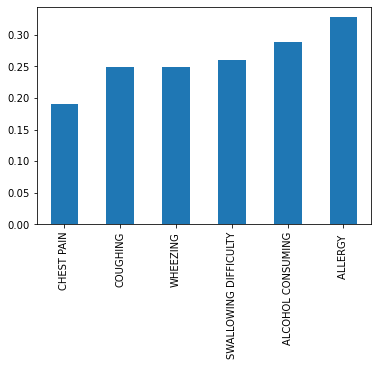

In [8]:
#Top 5 factors
data_no_cat.corr()['LUNG_CANCER_YES'].sort_values()[-7:-1].plot(kind='bar')
plt.show()

Now, considering the top 5 cp

# II. Model selection

Recall that the data is very imbalanced. Given that the dataset is small, I would try to oversample it.

In [9]:
#Target variable
y = data_no_cat['LUNG_CANCER_YES']

#Features
X = data_no_cat[['AGE', 'SMOKING', 'YELLOW_FINGERS', 'PEER_PRESSURE', 'ANXIETY',
       'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'GENDER_M']]

X_over,y_over=RandomOverSampler().fit_resample(X,y)

#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, random_state=42)

### 1) Linear regression

In [10]:
#Build model
lm_model = LinearRegression()

#Fit model
lm_model.fit(X_train, y_train) 

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [11]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.6512260953662646.  The rsquared on the test data was 0.6713081079096131.


It doesn't perform well, let's consider ensemble models instead.

To decide on the best model, we will focus on recall, and the AUC score.
The AUC score will be useful because our model is binary while recall is important as the cost of false negatives is greater than that of false positives.

### 3) Random Forest

In [12]:
#Fit RF model with min value of n_estimator after which performance no longer increases
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = rf_model.predict(X_test)
y_train_preds = rf_model.predict(X_train)

#Score using your model
test_score= roc_auc_score(y_test, y_test_preds)
train_score = roc_auc_score(y_train, y_train_preds)

In [13]:
print("The AUC score on the training data was {}.  The AUC score on the test data was {}.".format(train_score, test_score))

The AUC score on the training data was 0.9972222222222222.  The AUC score on the test data was 0.9833333333333334.


### 2) GBT

In [14]:
#Tune hyperparameters
est = np.arange(100,800,100)
test_score = []
train_score = []
for i in est:
    gbt_model = GradientBoostingClassifier(n_estimators = i, random_state=42)

    gbt_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = gbt_model.predict(X_test)
    y_train_preds = gbt_model.predict(X_train)

    #Score using your model
    test_score.append(roc_auc_score(y_test, y_test_preds))
    train_score.append(roc_auc_score(y_train, y_train_preds))

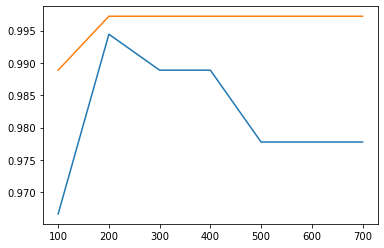

In [15]:
plt.plot(est, test_score, est, train_score);

We choose 500 as the best n_estimators.

In [16]:
gbt_model = GradientBoostingClassifier(max_depth = 5, n_estimators=500, random_state=42)

gbt_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = gbt_model.predict(X_test)
y_train_preds = gbt_model.predict(X_train)

#Score using your model
test_score=roc_auc_score(y_test, y_test_preds)
train_score = roc_auc_score(y_train, y_train_preds)

In [17]:
print("The AUC score on the training data was {}.  The AUC score on the test data was {}.".format(train_score, test_score))

The AUC score on the training data was 0.9972222222222222.  The AUC score on the test data was 0.9944444444444445.


By tuning the n_estimators, we have increased the test score from 0.95 to 0.9944.

### Chosen model

Between the three models, we choose to focus on GBT which performs the best

# III. Feature selection

Using the GBT model, we tempt to remove some of the suggested features and evaluate if performance increases.

With all the features, we have a auc_test of 0.994 

Without anxiety or gender, the test r2 has reduced to 0.988 or 0.95 respectively.

Removing the other features mentioned also reduces performance. We will thus keep all the features provided

# IV. Model evaluation

In [18]:
test_recall = recall_score(y_test, y_test_preds)
train_recall = recall_score(y_train, y_train_preds)
print("The recall on the training data was {}.  The recall on the test data was {}.".format(train_recall, test_recall))

The recall on the training data was 0.9944444444444445.  The recall on the test data was 0.9888888888888889.


In [19]:
test_f1 = f1_score(y_test, y_test_preds)
train_f1 = f1_score(y_train, y_train_preds)
print("The f1 score on the training data was {}.  The f1 score on the test data was {}.".format(train_f1, test_f1))

The f1 score on the training data was 0.9972144846796658.  The f1 score on the test data was 0.9944134078212291.


In [20]:
print(precision_score(y_test, y_test_preds))
print(precision_score(y_train, y_train_preds))

1.0
1.0


In [21]:
print(accuracy_score(y_test, y_test_preds))
print(accuracy_score(y_train, y_train_preds))

0.994413407821229
0.997229916897507


The recall, f1 score and AUC scores are all extremely good.

A good recall means false negatives will be avoided. This is good in our case because we want to identify as many lung cancer individuals as possible.

We note that the precision is of 1 which indicates that there are no false positives. Although this seems like good news, it might be indicative that our model predicts that everyone has cancer.

Nevertheless, the f1 score is good as well, showcasing that a good balance between the two has been achieved.

# Conclusion

In [55]:
features= pd.DataFrame(data = [gbt_model.feature_importances_], columns = X.columns)
features.iloc[0].sort_values(ascending=False)

ALLERGY                  0.247333
FATIGUE                  0.158307
SWALLOWING DIFFICULTY    0.132628
AGE                      0.130353
ALCOHOL CONSUMING        0.068127
PEER_PRESSURE            0.060560
YELLOW_FINGERS           0.046528
CHRONIC DISEASE          0.044368
WHEEZING                 0.031013
ANXIETY                  0.021406
GENDER_M                 0.015561
SMOKING                  0.015343
SHORTNESS OF BREATH      0.014840
COUGHING                 0.011982
CHEST PAIN               0.001651
Name: 0, dtype: float64

We can now predict whether or not someone will have lung cancer based on a number of characteristics.

As believed earlier, age is indeed one of the top 5 most important feature in our model. While it might come as a surprise that gender is so down the list, it might be explained by the fact that alcohol consumption isn't. Indeed, as explained earlier, gender and alcohol are highly correlated and only one of the two should thus be prioritised.